# MNIST Classification using OOP Approach

This notebook demonstrates an object-oriented solution for MNIST image classification.
Three models are implemented:

1. **Random Forest** – using scikit-learn.
2. **Feed-Forward Neural Network (FFNN)** – using PyTorch.
3. **Convolutional Neural Network (CNN)** – using PyTorch.

Each model implements the common interface `MnistClassifierInterface` with two abstract methods:
- `train`: for training the model.
- `predict`: for predicting on new data.

The models are then wrapped inside a single `MnistClassifier` class which selects the appropriate model based on an algorithm parameter (`"rf"`, `"nn"`, or `"cnn"`).


## Imports and Setup


Import required libraries

In [9]:
from abc import ABC, abstractmethod
import numpy as np
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# PyTorch libraries for neural network implementations
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


## MNIST Dataset Analysis and Demonstration

This notebook provides a brief analysis and demonstration of the MNIST dataset.  
The MNIST dataset contains 70,000 grayscale images of handwritten digits (0-9), each sized 28x28 pixels.

Loading MNIST dataset...
Data shape: (70000, 784)
Labels shape: (70000,)


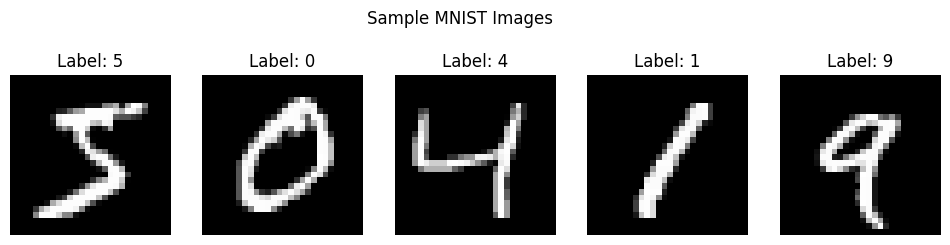

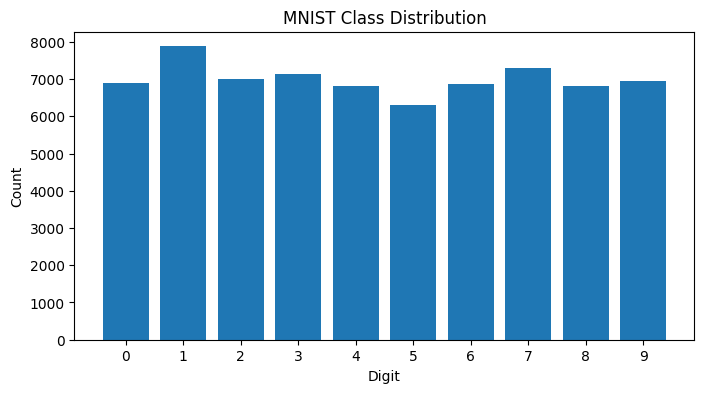

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import pandas as pd

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)

# Convert DataFrame to numpy array for easier indexing and normalize pixel values to [0,1]
X = mnist.data.astype(np.float32).to_numpy() / 255.0  
y = mnist.target.astype(np.int64).to_numpy()

# Display basic information about the dataset
print("Data shape:", X.shape)
print("Labels shape:", y.shape)

# Create a DataFrame for labels to perform some analysis
df_labels = pd.DataFrame({'label': y})

# Plot a few sample images with their corresponding labels
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    # Reshape the flat vector into 28x28 image
    img = X[i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.suptitle("Sample MNIST Images")
plt.show()

# Analyze class distribution
class_counts = df_labels['label'].value_counts().sort_index()

# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("MNIST Class Distribution")
plt.show()


## Define the Common Interface

We define an abstract base class `MnistClassifierInterface` with two methods: `train` and `predict`.

In [11]:
class MnistClassifierInterface(ABC):
    @abstractmethod
    def train(self, X_train, y_train):
        pass

    @abstractmethod
    def predict(self, X):
        pass

## Random Forest Classifier Implementation

This class uses scikit-learn's `RandomForestClassifier` to implement the MNIST classifier.


In [12]:
class RandomForestMnistClassifier(MnistClassifierInterface):
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X):
        return self.model.predict(X)

## Feed-Forward Neural Network Implementation

The feed-forward network consists of two hidden layers. Input images (28x28 pixels) are flattened to a 784-dimensional vector.


Define the Feed-Forward Neural Network model

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.network(x)


class FeedForwardNeuralNetworkClassifier(MnistClassifierInterface):
    def __init__(self, epochs=5, batch_size=64, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize the FFNN model, loss function, and optimizer
        self.model = FeedForwardNN().to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train(self, X_train, y_train):
        # Convert training data to torch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)

        # Create a DataLoader for batch processing
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu().numpy()

## Convolutional Neural Network Implementation

The CNN model is built with two convolutional layers followed by max pooling, then fully connected layers.

Define the CNN model

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

class ConvolutionalNeuralNetworkClassifier(MnistClassifierInterface):
    def __init__(self, epochs=5, batch_size=64, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize the CNN model, loss function, and optimizer
        self.model = CNN().to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train(self, X_train, y_train):
        # Reshape the input data to (n_samples, 1, 28, 28)
        X_train_reshaped = X_train.reshape(-1, 1, 28, 28)
        X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)

        # Create a DataLoader for batch processing
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    def predict(self, X):
        # Reshape input data to (n_samples, 1, 28, 28)
        X_reshaped = X.reshape(-1, 1, 28, 28)
        self.model.eval()
        X_tensor = torch.tensor(X_reshaped, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu().numpy()

## Unified MNIST Classifier Wrapper

The `MnistClassifier` class takes an algorithm parameter (`"rf"`, `"nn"`, or `"cnn"`) and instantiates the corresponding model.

In [15]:
class MnistClassifier:
    def __init__(self, algorithm="rf"):
        if algorithm.lower() == "rf":
            self.model = RandomForestMnistClassifier()
        elif algorithm.lower() == "nn":
            self.model = FeedForwardNeuralNetworkClassifier()
        elif algorithm.lower() == "cnn":
            self.model = ConvolutionalNeuralNetworkClassifier()
        else:
            raise ValueError("Unsupported algorithm. Choose 'rf', 'nn', or 'cnn'.")

    def train(self, X_train, y_train):
        self.model.train(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

## Data Preprocessing

Split dataset into training and test sets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Demonstration and Evaluation

We now demonstrate training and predicting with each of the three models.

In [18]:
# Evaluate Random Forest Classifier
print("----- Random Forest Classifier -----")
rf_classifier = MnistClassifier(algorithm="rf")
start_time = time.time()
rf_classifier.train(X_train, y_train)
pred_rf = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, pred_rf)
print("Random Forest Accuracy:", rf_accuracy)
print("Time taken: {:.2f} seconds\n".format(time.time() - start_time))

----- Random Forest Classifier -----
Random Forest Accuracy: 0.9675
Time taken: 2.88 seconds



In [19]:
# Evaluate Feed-Forward Neural Network Classifier
print("----- Feed-Forward Neural Network -----")
nn_classifier = MnistClassifier(algorithm="nn")
start_time = time.time()
nn_classifier.train(X_train, y_train)
pred_nn = nn_classifier.predict(X_test)
nn_accuracy = accuracy_score(y_test, pred_nn)
print("Feed-Forward NN Accuracy:", nn_accuracy)
print("Time taken: {:.2f} seconds\n".format(time.time() - start_time))

----- Feed-Forward Neural Network -----
Epoch [1/5], Loss: 0.3529
Epoch [2/5], Loss: 0.1482
Epoch [3/5], Loss: 0.1011
Epoch [4/5], Loss: 0.0764
Epoch [5/5], Loss: 0.0579
Feed-Forward NN Accuracy: 0.9704285714285714
Time taken: 6.14 seconds



In [20]:
# Evaluate Convolutional Neural Network Classifier
print("----- Convolutional Neural Network -----")
cnn_classifier = MnistClassifier(algorithm="cnn")
start_time = time.time()
cnn_classifier.train(X_train, y_train)
pred_cnn = cnn_classifier.predict(X_test)
cnn_accuracy = accuracy_score(y_test, pred_cnn)
print("CNN Accuracy:", cnn_accuracy)
print("Time taken: {:.2f} seconds\n".format(time.time() - start_time))

----- Convolutional Neural Network -----
Epoch [1/5], Loss: 0.1943
Epoch [2/5], Loss: 0.0503
Epoch [3/5], Loss: 0.0354
Epoch [4/5], Loss: 0.0256
Epoch [5/5], Loss: 0.0203
CNN Accuracy: 0.9892857142857143
Time taken: 8.36 seconds



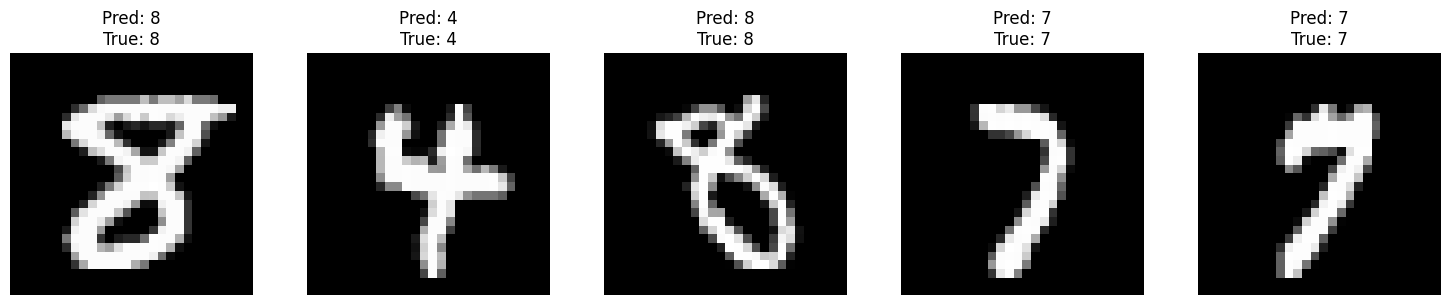

In [21]:
# Select 5 images from the test subset
sample_images = X_test[:5]
sample_true_labels = y_test[:5]

# Use the previously trained CNN classifier (cnn_classifier) to predict the labels
sample_predicted_labels = cnn_classifier.predict(sample_images)

# Plot the 5 images along with predicted (and true) labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for idx, ax in enumerate(axes):
    # Reshape the flat image vector into 28x28
    ax.imshow(sample_images[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Pred: {sample_predicted_labels[idx]}\nTrue: {sample_true_labels[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()
